# Classifying Images using an RNN

In this demo we will use recurrent neural nets (RNNs) for a slightly non-standard application: image classification. To be clear, RNN-type architectures have been typically used for applications involving sequences (such as text, audio, time series, etc.)

For text applications, one has to somehow transform a sequence of characters into a sequence of numerical (vector) *encodings*. We will get into encodings in a later demo. 

Image data, on the other hand, is already in vector form. Let us imagine a setting where the pixels of an image are presented to the classifier in sequential form. Think of a problem where an image is being "raster-scanned", and where the classifier has to continuously updates its beliefs as new pixels come in. We will use a recurrent neural network to solve this problem.


# Data loading and preparation

We will use the familiar Fashion-MNIST dataset. The following code (until building the data-loader) should be standard.

In [1]:
import torch

from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.FashionMNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()

)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


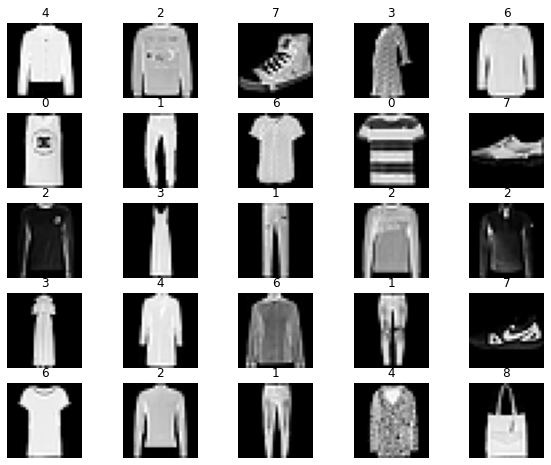

In [2]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [3]:
from torch.utils.data import DataLoader
dataloaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}

# Setting up the RNN model

Recall that FashionMNIST images are of size $28 \times 28$. We will pretend that each row of any input image is a token (of length 28), which is presented sequentially to the RNN. Therefore there are 28 such tokens for each sequence (image).

We will assume [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) recurrent units with 2 layers and hidden size 128, followed by an output linear layer that performs the classification.


In [4]:
from torch import nn
import torch.nn.functional as F

In [5]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 4
learning_rate = 0.01

The key is to set up the RNN correctly. Note that the length of the sequence is irrelevant to the model: it can process sequences of any length.

In [6]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, hidden = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :])
        return out
        
        
model = RNN(input_size, hidden_size, num_layers, num_classes)
print(model)

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


# Training the model

Everything looks good! Let us now train the model using the (familiar) cross-entropy loss and the Adam optimizer. We will use backpropagation-through-time (BPTT), which Pytorch automatically handles under the hood while calling `optimizer_backward()`.


In [7]:
loss_func = nn.CrossEntropyLoss()
from torch import optim
optimizer = optim.Adam(model.parameters(), lr = 0.01) 

In [8]:
def train(num_epochs, model, loaders):
        
    # Train the model
    total_step = len(dataloaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(dataloaders['train']):
            
            images = images.reshape(-1, sequence_length, input_size)
            
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.2f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                


train(num_epochs, model, dataloaders)

Epoch [1/4], Step [100/600], Loss: 0.89
Epoch [1/4], Step [200/600], Loss: 0.57
Epoch [1/4], Step [300/600], Loss: 0.52
Epoch [1/4], Step [400/600], Loss: 0.37
Epoch [1/4], Step [500/600], Loss: 0.53
Epoch [1/4], Step [600/600], Loss: 0.34
Epoch [2/4], Step [100/600], Loss: 0.51
Epoch [2/4], Step [200/600], Loss: 0.46
Epoch [2/4], Step [300/600], Loss: 0.31
Epoch [2/4], Step [400/600], Loss: 0.32
Epoch [2/4], Step [500/600], Loss: 0.49
Epoch [2/4], Step [600/600], Loss: 0.43
Epoch [3/4], Step [100/600], Loss: 0.49
Epoch [3/4], Step [200/600], Loss: 0.28
Epoch [3/4], Step [300/600], Loss: 0.23
Epoch [3/4], Step [400/600], Loss: 0.25
Epoch [3/4], Step [500/600], Loss: 0.42
Epoch [3/4], Step [600/600], Loss: 0.20
Epoch [4/4], Step [100/600], Loss: 0.23
Epoch [4/4], Step [200/600], Loss: 0.32
Epoch [4/4], Step [300/600], Loss: 0.45
Epoch [4/4], Step [400/600], Loss: 0.26
Epoch [4/4], Step [500/600], Loss: 0.22
Epoch [4/4], Step [600/600], Loss: 0.45


# Testing

The loss looks decent enough! Let's test the model now. 

In [9]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['test']:
        images = images.reshape(-1, sequence_length, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total = total + labels.size(0)
        correct = correct + (predicted == labels).sum().item()
print('Test accuracy: {} %'.format(100 * correct / total))

Test accuracy: 87.17 %


In [10]:
sample = next(iter(dataloaders['test']))
imgs, lbls = sample

In [11]:
test_output = model(imgs[:10].view(-1, 28, 28))
predicted = torch.max(test_output, 1)[1].data.numpy().squeeze()
labels = lbls[:10].numpy()
print(f"Predicted label: {predicted}")
print(f"Actual label: {labels}")

Predicted label: [4 3 8 6 8 1 1 4 8 3]
Actual label: [4 0 8 6 8 1 1 4 8 3]


Not too bad! We get ~88% accuracy on FashionMNIST where the pixels are presented sequentially, which is comparable to what we got using regular dense architectures.

An advantage of RNN-based classification for images is that since RNNs work for variable-length inputs, it allows for declaring a class label even if the input is partially available (for example, if only the top one-third of the pixels were rasterized). Let's see how this would work.

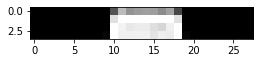

Predicted label: 3
Actual label: 1


In [22]:
idx = 32
img = imgs[idx]
num_rows = 4
img_crop = img[:,:num_rows,:]
test_output_on_crop = model(img_crop.view(-1, num_rows, 28))
predicted = torch.max(test_output_on_crop, 1)[1].data.numpy().squeeze()
labels = lbls[idx].numpy()
figure = plt.figure(figsize=(4, 4))
plt.imshow(img_crop.squeeze(),cmap='gray')
plt.show()
print(f"Predicted label: {predicted}")
print(f"Actual label: {labels}")